# Logistic Regression 
- 양성인지 음성인지 분류하는 모델
- 선형회귀로는 분류하기 어려움
- 시그모이드 같은 활성함수가 필요함

### 시그모이드 그리기

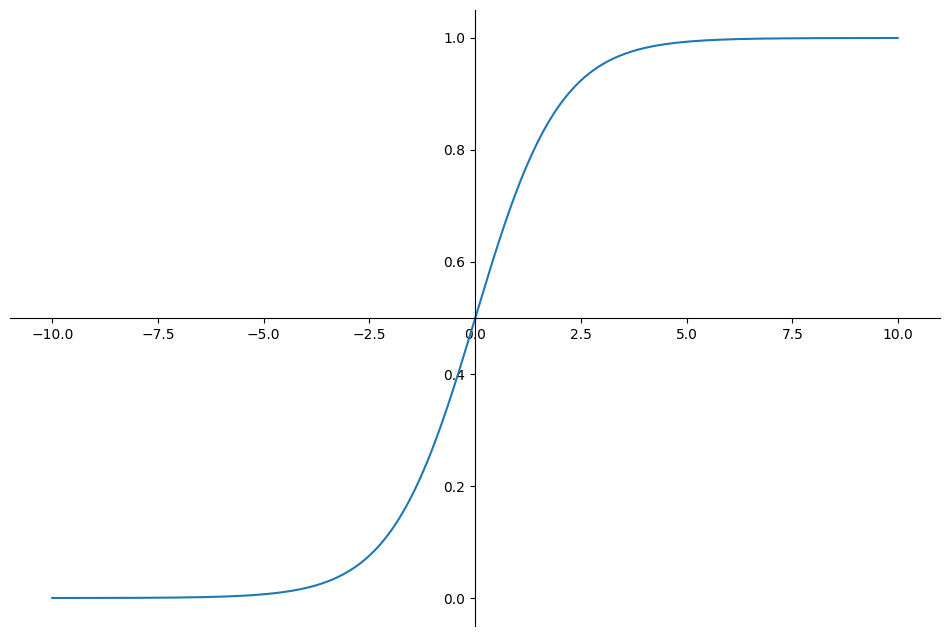

In [8]:
import numpy as np

z = np.arange(-10, 10, 0.01)
g = 1/(1+np.exp(-z))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
ax = plt.gca()

ax.plot(z, g)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')


---

# 와인데이터

### 와인 데이터셋 이용해 와인등급 로지스틱 분류

In [9]:
import pandas as pd

wine_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/wine.csv'
wine = pd.read_csv(wine_url, index_col=0)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### 와인등급 컬럼추가

In [11]:
wine['taste'] = [1. if grade > 5 else 0. for grade in wine['quality']]
X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

---

### 데이터셋 split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

### 로지스틱 모델 생성

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', random_state = 13)
lr.fit(X_train, y_train)

LogisticRegression(random_state=13, solver='liblinear')

### 정확도 측정

In [14]:
from sklearn.metrics import accuracy_score

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('Train acc: ', accuracy_score(y_train, y_pred_tr))
print('Test acc: ', accuracy_score(y_test, y_pred_test))

Train acc:  0.7427361939580527
Test acc:  0.7438461538461538


### Scaler 이용하여 Pipeline 구축

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('scaler', StandardScaler()),
             ('clf', LogisticRegression(solver='liblinear', random_state = 13))]

pipe = Pipeline(estimators)

### 파이프라인 이용한 학습
- 정확도 미세하지만 상승함

In [18]:
pipe.fit(X_train, y_train)

y_pred_tr = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print('Train acc: ', accuracy_score(y_train, y_pred_tr))
print('Test acc: ', accuracy_score(y_test, y_pred_test))

Train acc:  0.7444679622859341
Test acc:  0.7469230769230769


### 모델 Decision Tree 와 Logistic Regression 비교

In [19]:
from sklearn.tree import DecisionTreeClassifier

wine_tree = DecisionTreeClassifier(max_depth=2, random_state = 13)
wine_tree.fit(X_train, y_train)

models = {'Logistic Regression':pipe, 'Decision Tree':wine_tree}

### AUC 그래프 이용한 모델 비교

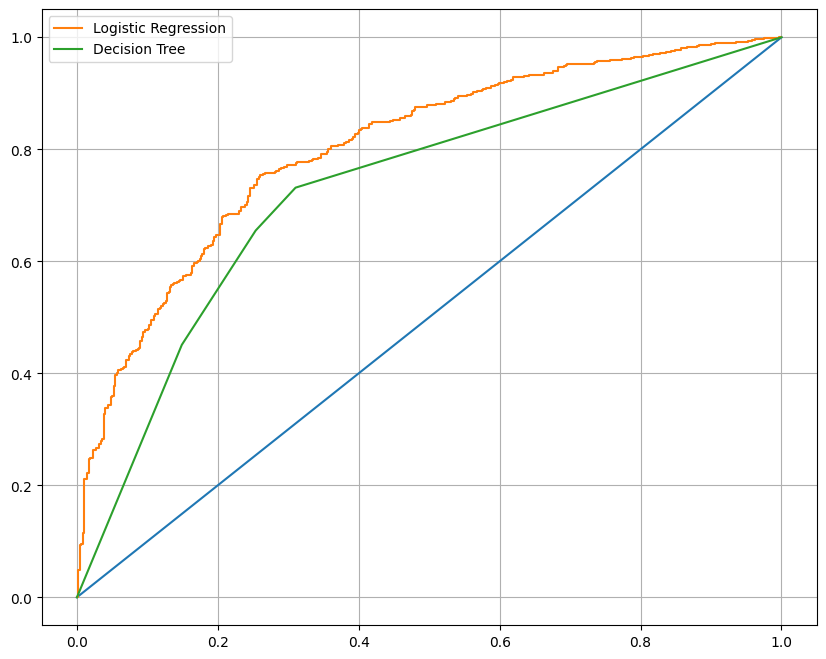

In [21]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1])
for model_name, model in models.items():
    pred = model.predict_proba(X_test)[:,1] # 두번째 컬럼이 1일 확률.
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label=model_name)
    
plt.grid()
plt.legend()
plt.show()

---

### Coefficient로 feture의 중요도 파악 가능

In [22]:
coeff = list(pipe['clf'].coef_[0])
labels = list(X_train.columns)

In [24]:
features = pd.DataFrame({'Features': labels, 'importance':coeff})
features

,Features,importance
0,fixed acidity,0.161491
1,volatile acidity,-0.773198
2,citric acid,-0.077182
3,residual sugar,0.615934
4,chlorides,-0.050697
5,free sulfur dioxide,0.266823
6,total sulfur dioxide,-0.304306
7,density,-0.483688
8,pH,0.104523
9,sulphates,0.303213


### 와인의 맛은 알콜, 당 성분에 따라 좋음

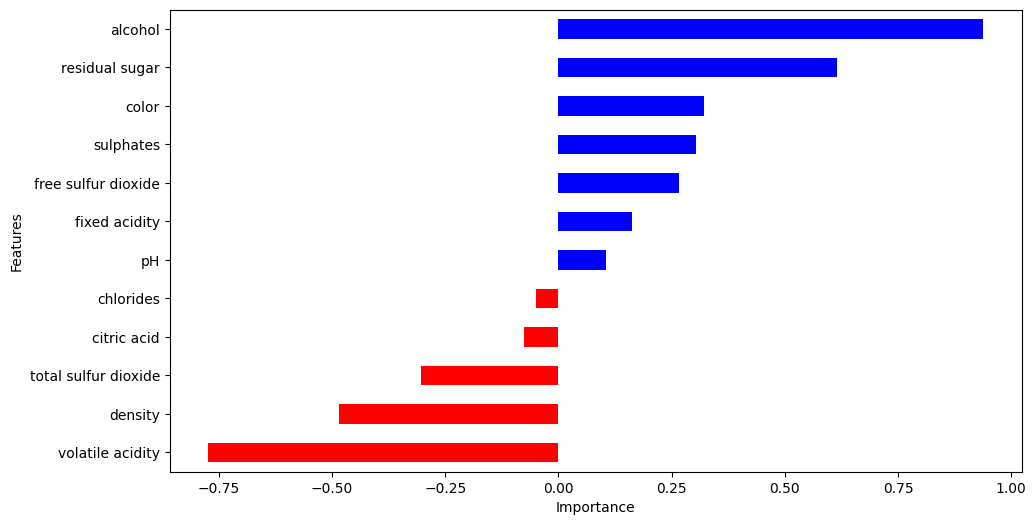

In [25]:
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features['importance'].plot(kind='barh',
                           figsize=(11,6),
                           color=features['positive'].map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')
plt.show()

---

 ### 성능 지표 확인 classification_report
- from sklearn.metrics 


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.62       477
         1.0       0.77      0.84      0.81       823

    accuracy                           0.74      1300
   macro avg       0.73      0.71      0.71      1300
weighted avg       0.74      0.74      0.74      1300



### confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, lr.predict(X_test))

array([[275, 202],
       [131, 692]], dtype=int64)

### threshold에 따른 Precision 정밀도 / Recall 재현율 커브 그래프

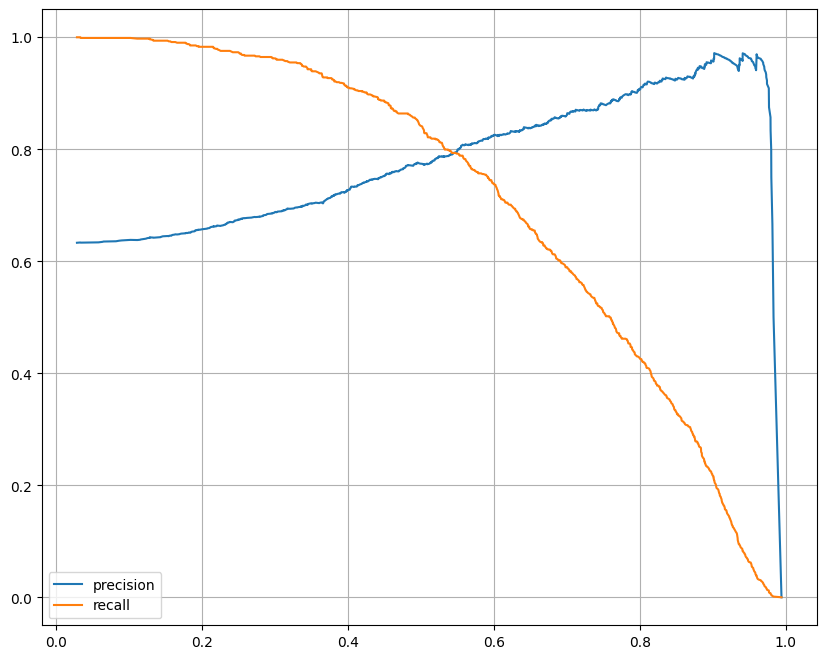

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

plt.figure(figsize=(10,8))
pred = lr.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred)
plt.plot(thresholds, precisions[: len(thresholds)], label='precision')
plt.plot(thresholds, recalls[: len(thresholds)], label='recall')
plt.grid();
plt.legend();
plt.show()

### Threshold가 0.5인 경우

In [41]:
pred_proba = lr.predict_proba(X_test)
pd.DataFrame(pred_proba[:3])

,0,1
0,0.405511,0.594489
1,0.509362,0.490638
2,0.102245,0.897755


#### 우측에 y라벨 넣고 싶음

In [42]:
import numpy as np
pd.DataFrame(np.concatenate([pred_proba, y_pred_test.reshape(-1, 1)], axis=1)[:3])

,0,1,2
0,0.405511,0.594489,1.0
1,0.509362,0.490638,0.0
2,0.102245,0.897755,1.0


### Threshold 0.6으로 바꿈 - Binarizer

In [43]:
pd.DataFrame(pred_proba[:3])

,0,1
0,0.405511,0.594489
1,0.509362,0.490638
2,0.102245,0.897755


In [45]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
pred_bin = binarizer.transform(pred_proba)[:, 1]
pd.DataFrame(pred_bin[:3])

,0
0,0.0
1,0.0
2,1.0


In [37]:
print(classification_report(y_test, pred_bin))

              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67       477
         1.0       0.82      0.74      0.78       823

    accuracy                           0.73      1300
   macro avg       0.72      0.73      0.72      1300
weighted avg       0.75      0.73      0.74      1300



In [38]:
confusion_matrix(y_test, pred_bin)

array([[348, 129],
       [216, 607]], dtype=int64)